## Import Library 

In [1]:
import os
import json
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

## Read Parameter Radar

In [3]:
# Pembacaan Parameter Dataset
filename = "parameter.json"
with open(filename, 'r') as f:
    params = json.load(f)

## Read Data .csv

In [4]:
# Function to read dataset.csv
def read_csv(filepath, row=True):
    df = pd.read_csv(filepath, header=None)
    if row: # row data
        data = df.T.values.tolist()[0]
    else: # comma-separated column data
        data = df.values.tolist()[0]
    return data
def read_raw(filepath):
    raw = []
    with open(filepath) as f:
        # read all lines into list of string
        lines = f.readlines()
        for line in lines:
            # remove leading and trailing white spaces and split by comma delimiter
            raw += line.strip().split(',')
    raw = [complex(s.replace('i', 'j')) for s in raw]
    return raw

## Read Data From Folder 
*** Select the folder where you store your dataset.

*** Copy the path to the folder.

In [36]:

# Read Data --------------------------------------------
# set dataset folder path
dataset_folder = 'F:\MATERI KULIAH\TESIS\REFERENSI\Children Dataset\Children Dataset'
radar_raw_folder = os.path.join(dataset_folder, "FMCW Radar\Rawdata")
radar_vital_folder = os.path.join(dataset_folder, "FMCW Radar\Heart Rate & Breathing Rate")
ref_raw_folder = os.path.join(dataset_folder, "Nihon Kohden\Heartbeat & Breathing Waveform")
ref_vital_folder = os.path.join(dataset_folder, "Nihon Kohden\Heart Rate & Breathing Rate")
subject_stats_folder = os.path.join(dataset_folder, "Participant\Human Data")
subject_photo_folder = os.path.join(dataset_folder, "Participant\Picture")

# Subjec
subject_id = 7
radar_raw_path = os.path.join(radar_raw_folder, f"Rawdata_{subject_id}.csv")
raw_data = read_raw(radar_raw_path)## Pemanggilan Dataset Dari Folder 
# Merubah data list ke Array 
raw_data = np.asarray(raw_data, dtype=complex)
n_samples = raw_data.shape[0]//params['n_rx']
# print(raw_data.shape[0])
raw_radar = raw_data.reshape(params['n_rx'],n_samples, order='C')
raw_new = raw_radar.reshape((params['n_rx'],params['n_adc']*params['n_chirp'],-1), order='F')
#read heart rate (HR) and breath rate (BR) reading from reference device
ref_hr_path = os.path.join(ref_vital_folder, f"Ref_Heart_{subject_id}.csv")
ref_br_path = os.path.join(ref_vital_folder, f"Ref_Breath_{subject_id}.csv")
# Radar Paper
# read heart rate (HR) and breath rate (BR) estimation from radar
hr_radar_path = os.path.join(radar_vital_folder, f"Heart_{subject_id}.csv")
br_radar_path = os.path.join(radar_vital_folder, f"Breath_{subject_id}.csv")
#df_radar = pd.read_csv(hr_radar_path, header=None)
hr_radar = read_csv(hr_radar_path, row=True)
br_radar = read_csv(br_radar_path, row=True)
#df_hr = pd.read_csv(ref_hr_path, header=None)
hr = read_csv(ref_hr_path, row=False)
br = read_csv(ref_br_path, row=False)
# Waveform 
radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{subject_id}.csv")
radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{subject_id}.csv")
br_wave =np.array(read_csv(radar_br_wave_path))
hr_wave =np.array(read_csv(radar_hr_wave_path,row=True))

## Range FFT and MTI 

In [37]:
def Range_FFT(InputData):
    OutputData = np.zeros((params['n_rx'], params['n_fft'], params['data_len']), dtype=complex)
    dc_removal = np.zeros((params['n_rx'], params['n_fft']//2, params['data_len']), dtype=complex)
    for i in range(params['n_rx']):
        for j in range(params['data_len']):
            window = np.hamming(params['n_fft'])
            dc_removal[i,:,j]= InputData[i,:,j] - np.mean(InputData[i,:,j])
            OutputData[i,:,j]= fft((dc_removal[i,:,j]), n=1024)
    return OutputData

def MTI(hasil_fft):
    clutter = np.zeros((hasil_fft.shape[0], params['n_fft'], hasil_fft.shape[-1]),dtype=complex)
    OutputData = np.zeros((hasil_fft.shape[0],params['n_fft']//2, hasil_fft.shape[-1]),dtype=complex)
    alpha = 0.01
    for i in np.arange(hasil_fft.shape[0]):
        for j in np.arange(1,hasil_fft.shape[-1]):
            clutter[i,:,j] = np.dot(alpha,hasil_fft[i,:,j])+ np.dot((1-alpha),clutter[i,:,j-1])
            OutputData[i,:,j] = hasil_fft[i,np.arange(params['n_fft']//2),j]-(clutter[i,range(0, params['n_fft']//2),j])
    return OutputData

In [38]:
# Lakukan proses FFT
FFT_hasil = Range_FFT(raw_new) # hasil FFT
Hasil_mti = MTI(FFT_hasil)

In [39]:
# Hasil MTI untuk setiap antena 
Antena1 = Hasil_mti[0,:,:]
Antena2 = Hasil_mti[1,:,:]
Antena3 = Hasil_mti[2,:,:]
Antena4 = Hasil_mti[3,:,:]

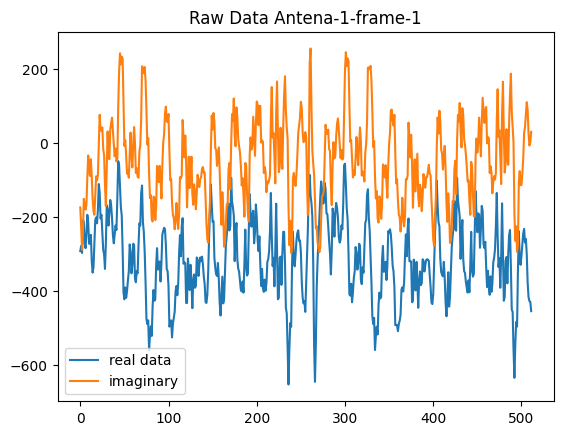

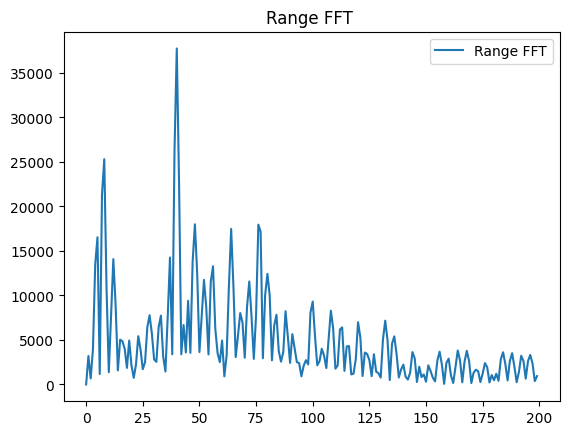

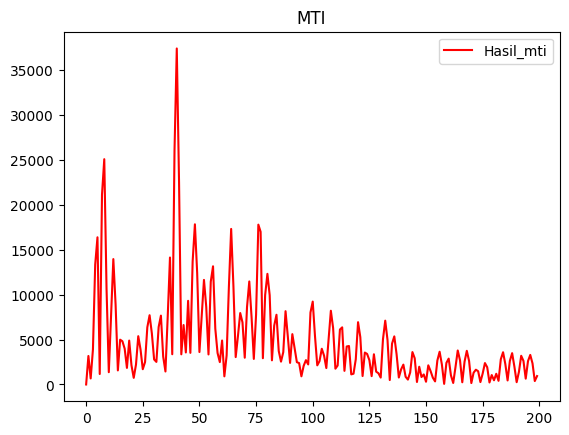

In [40]:
# Visualisasi Data 
plt.figure(1)
plt.title("Raw Data Antena-1-frame-1")
plt.plot(raw_new[0,:,1].real,label="real data")
plt.plot(raw_new[0,:,1].imag,label="imaginary")
plt.legend()
plt.figure(2)
plt.title("Range FFT ")
plt.plot(abs(FFT_hasil[0,:,1][:200]),label="Range FFT")
plt.legend()
plt.figure(3)
plt.title("MTI")
plt.plot(abs(Hasil_mti[0,:,1][:200]),label="Hasil_mti",color='r')
plt.legend()


## Target Selection

###  Pilih target sesuai ketentuan pengambilan data 
** Target dalam paper berada pada jarak 0.5 m 

In [41]:
import numpy as np

# Map Lokasinya 
def map_loc(data_mti):
    Range_Map_An1 = []
    index_max = []
    for i in range(1, params['data_len']):
        # Input data From MTI each Antenna 
        awal_an1 = data_mti[:, i] 
        abs_mti_1 = abs(awal_an1)
        peak_loc_an1 = np.argmax(abs_mti_1[25:60]) #pilih batas jarak
        rslt_peak_1 = 25 + peak_loc_an1
        if i > 1 and abs(rslt_peak_1 - index_max[-1]) == 10:
            # Jika perbedaan adalah 10, pilih peak tertinggi kedua
            abs_mti_1[peak_loc_an1] = 0  # Hilangkan peak pertama
            peak_loc_an1 = np.argmax(abs_mti_1[25:60])
            rslt_peak_1 = 25 + peak_loc_an1
        map_loc_an1 = awal_an1[rslt_peak_1]
        index_max.append(abs(rslt_peak_1))
        Range_Map_An1.append(map_loc_an1)
    return index_max, Range_Map_An1

# Contoh penggunaan
map_locA1, Map_loc_An1 = np.array(map_loc(Antena1))
map_locA2, Map_loc_An2 = np.array(map_loc(Antena2))
map_locA3, Map_loc_An3 = np.array(map_loc(Antena3))
map_locA4, Map_loc_An4 = np.array(map_loc(Antena4))


In [42]:
# Phase Extraction
from f_dacm import dacm
from f_noise_RM import remove_noise

DACM_An1 = np.array(dacm(np.array(Map_loc_An1)))
DACM_An2 = np.array(dacm(np.array(Map_loc_An2)))
DACM_An3 = np.array(dacm(np.array(Map_loc_An3)))
DACM_An4 = np.array(dacm(np.array(Map_loc_An4)))


Text(0.5, 0, 'Number of Samples')

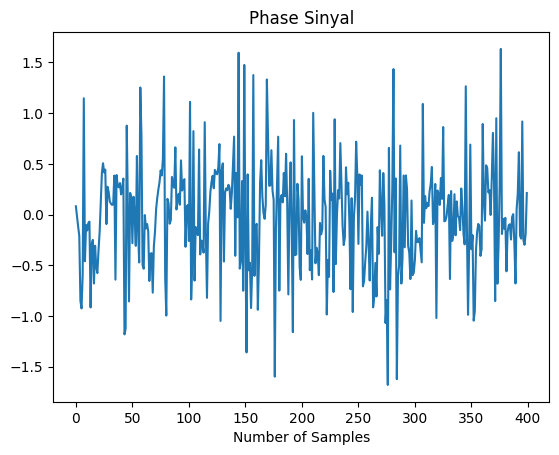

In [43]:
# 
plt.title("Phase Sinyal")
plt.plot(DACM_An1[:400])
plt.xlabel("Number of Samples")

In [44]:
# from f_noise_RM import remove_noise
NR_1 = remove_noise(DACM_An1)
NR_2 = remove_noise(DACM_An2)
NR_3 = remove_noise(DACM_An3)
NR_4 = remove_noise(DACM_An4)

## Bandpass Filter

In [45]:
from scipy.signal import butter, sosfiltfilt, filtfilt,lfilter
def _butter_bandpass1(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype="band", output="sos")
    # b, a = butter(order, [low, high], btype='band')
    return sos
def _butter_bandpass2(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # sos = butter(order, [low, high], btype="band", output="sos")
    b, a = butter(order, [low, high], btype='band')
    return b,a
def butter_bandpass_filter(signal, lowcut, highcut, fs, order):
    sos = _butter_bandpass1(lowcut, highcut, fs, order=order)
    b,a = _butter_bandpass2(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, signal)
    y2 = filtfilt(b,a, signal)
    return y


In [46]:
low = 3/60
high = 55/60
fs = 20
BPF_RR1= np.array(butter_bandpass_filter(NR_1,low,high,fs,order=3))
BPF_RR2 = np.array(butter_bandpass_filter(NR_2,low,high,fs,order=3))
BPF_RR3 = np.array(butter_bandpass_filter(NR_3,low,high,fs,order=3))
BPF_RR4 = np.array(butter_bandpass_filter(NR_4,low,high,fs,order=3))

In [47]:
lowhr =60/60
highhr = 3.0
fs = 20
BPF_HR1 = np.array(butter_bandpass_filter(NR_1,lowhr,highhr,fs,order=6))
BPF_HR2 = np.array(butter_bandpass_filter(NR_2,lowhr,highhr,fs,order=6))
BPF_HR3 = np.array(butter_bandpass_filter(NR_3,lowhr,highhr,fs,order=6))
BPF_HR4 = np.array(butter_bandpass_filter(NR_4,lowhr,highhr,fs,order=6))

In [48]:
from f_fft_sinyal import fft_sinyal
def calculate_hr_rr(data_rr,data_hr):
    data_rr = np.array(data_rr)
    data_hr = np.array(data_hr)
    freq_rr, fft_rr = fft_sinyal(data_rr)
    freq_hr, fft_hr = fft_sinyal(data_hr)
    peak1 = np.argmax(fft_rr[:20])
    peak2 = np.argmax(fft_hr[:80])
    bpm_rr = freq_rr[peak1]*60
    bpm_hr = freq_hr[peak2]*60
    return bpm_rr, bpm_hr

In [49]:
start = 0
counter = 0
An1_RR = BPF_RR1
An2_RR = BPF_RR2
An3_RR = BPF_RR3
An4_RR = BPF_RR4
An1_HR = BPF_HR1
An2_HR = BPF_HR2
An3_HR = BPF_HR3
An4_HR = BPF_HR4


HR_an1 =[]
HR_an2 =[]
HR_an3 =[]
HR_an4 =[]
RR_an1 =[]
RR_an2 =[]
RR_an3 =[]
RR_an4 =[]
while counter < 280:  # Changed the loop condition to run for 280 iterations
        if start + 400 < len(An1_RR):
            An1_segment_RR = An1_RR[start:start + 400]
            An2_segment_RR = An2_RR[start:start + 400]
            An3_segment_RR = An3_RR[start:start + 400]
            An4_segment_RR = An4_RR[start:start + 400]
            # HR
            An1_segment_HR = An1_HR[start:start + 400]
            An2_segment_HR = An2_HR[start:start + 400]
            An3_segment_HR = An3_HR[start:start + 400]
            An4_segment_HR = An4_HR[start:start + 400]

        else:
            An1_segment_RR = An1_RR[start:]
            An2_segment_RR = An2_RR[start:]
            An3_segment_RR = An3_RR[start:]
            An4_segment_RR = An4_RR[start:]
            #HR 
            An1_segment_HR = An1_HR[start:]
            An2_segment_HR = An2_HR[start:]
            An3_segment_HR = An3_HR[start:]
            An4_segment_HR = An4_HR[start:]
        # Select The IMF 
        Rr1,Hr1 = calculate_hr_rr(An1_segment_RR,An1_segment_HR)
        Rr2,Hr2 = calculate_hr_rr(An2_segment_RR,An2_segment_HR)
        Rr3,Hr3 = calculate_hr_rr(An3_segment_RR,An3_segment_HR)
        Rr4,Hr4 = calculate_hr_rr(An4_segment_RR,An4_segment_HR)

        # rr1,hr1 = calculate_hr_rr(u_rr1, u_hr1)
        # rr2,hr2 = calculate_hr_rr(u_rr2, u_hr2)
        # rr3,hr3 = calculate_hr_rr(u_rr3, u_hr3)
        # rr4,hr4 = calculate_hr_rr(u_rr4, u_hr4) 
       
    
        # HR_an1.append(hr1)
        # HR_an2.append(hr2)
        # HR_an3.append(hr3)
        # HR_an4.append(hr4)
        # RR_an1.append(rr1)
        # RR_an2.append(rr2)
        # RR_an3.append(rr3)
        # RR_an4.append(rr4)
        HR_an1.append(Hr1)
        HR_an2.append(Hr2)
        HR_an3.append(Hr3)
        HR_an4.append(Hr4)
        RR_an1.append(Rr1)
        RR_an2.append(Rr2)
        RR_an3.append(Rr3)
        RR_an4.append(Rr4)

        counter += 1
        start = start + 20



## Kalman Filter

In [50]:
# Kalman 
import numpy as np 

def kalman_filter(z_ppg1):

    Q=3**2
    R=100**2
#     Q=4**2;                    
#     R=10**2;

    count=0
    countmax=5
    imax=3

    xposteriori=z_ppg1[0]
    res = np.zeros(len(z_ppg1))
    res[0]=z_ppg1[0]
    Pposteriori=0
    hasil =[]

    for i in range (1, len(z_ppg1)):

        xpriori=xposteriori
        Ppriori=Pposteriori+Q

        S=Ppriori+R
        gain=Ppriori/S

        inn1=z_ppg1[i]-xpriori

        if (((count==countmax or i<imax) and ~np.isnan(inn1))):
            inn=inn1
            xposteriori=xpriori+gain*inn
            Pposteriori=(1-gain)*Ppriori
            if(count==countmax ):
                xposteriori=0.5*(z_ppg1[i]+xpriori)
            count=0

        else:
            count=count+1
            xposteriori=xpriori
            Pposteriori=Ppriori

        res[i]=xposteriori
        hasil.append(xposteriori)

    return hasil

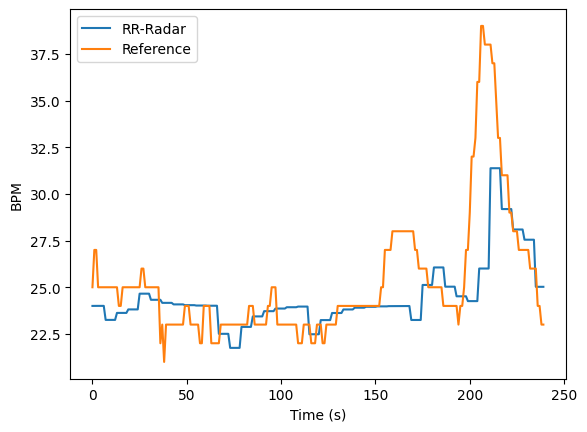

In [54]:
# RR 
RR_an1 = np.array(RR_an1)
RR_an2 = np.array(RR_an2)
RR_an3 = np.array(RR_an3)
RR_an4 = np.array(RR_an4)
TOTAL_RR = (RR_an1+RR_an2+RR_an3+RR_an4)/4 
Kalman_rr = kalman_filter(TOTAL_RR)
RR_ref = br[21:261]
plt.plot(Kalman_rr[:240],label ="RR-Radar")
plt.plot(RR_ref, label="Reference")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend()

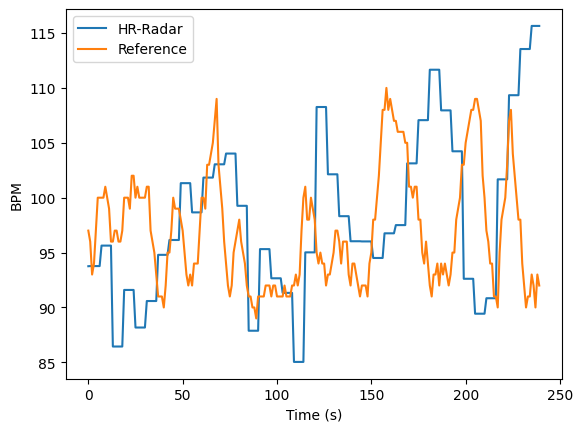

In [53]:
# RR 
HR_an1 = np.array(HR_an1)
HR_an2 = np.array(HR_an2)
HR_an3 = np.array(HR_an3)
HR_an4 = np.array(HR_an4)
TOTAL_HR = (HR_an1+HR_an2+HR_an3+HR_an4)/4 
Kalman_Hr = kalman_filter(TOTAL_HR)
HR_ref = hr[21:261]
plt.plot(Kalman_Hr[:240],label ="HR-Radar")
plt.plot(HR_ref, label="Reference")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend()